# Подготовка к A/B-тесту

Перед проведением A/B-теста необходимо определить необходимый размер выборки, чтобы тест имел достаточную статистическую мощность.  
Используем следующую формулу:

$$
n = \frac{(Z_{\alpha/2} + Z_{\beta})^2 \cdot 2 \sigma^2}{\Delta^2}
$$

где:  
- $\alpha = 0.05$ — уровень значимости 
- $1 - \beta = 0.8$ — мощность  
- $\sigma = 3$ — стандартное отклонение  
- $\Delta = 0.35$ — минимально значимый эффект (MDE)  
- $Z_{\alpha/2} = 1.96$ и $Z_{\beta} = 0.84$ — квантили стандартного нормального распределения  

**Важно:** В реальных A/B-тестах значения $\sigma$ (стандартного отклонения) и $\Delta$ (MDE) должны основываться на исторических данных.


In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import boto3
from io import StringIO
import pingouin as pg
from pprint import pprint

In [5]:
# Исходные данные
alpha = 0.05
power = 0.8
std = 3
mde = 0.35

z_alpha_2 = stats.norm.ppf(1 - alpha / 2)  # 1.96
z_beta = stats.norm.ppf(power)  # 0.84


n_per_group = ((z_alpha_2 + z_beta) ** 2 * 2 * std**2) / (mde**2)
print('Размер выборки на группу:', n_per_group)

Размер выборки на группу: 1153.304777292111


### Итоговый размер выборки и ожидаемая длительность теста  

В результате расчета получили, что для достижения требуемой статистической мощности необходимо **1153 человека на каждую группу**.  

Так как в нашем тесте ежедневно генерируется по **50 человек** в каждую группу, ожидаемая длительность эксперимента составит:  

$$
\frac{1153}{50} \approx 24 \text{ дня}
$$  

**Важно:** Продолжительность теста может изменится в зависимости от накопленных данных и динамического порога значимости.  


# Анализ результатов  

После завершения A/B-теста необходимо провести более детальный анализ результатов, чтобы убедиться в надежности выводов.  

Основные этапы анализа:  
- **Проверка распределения данных** — визуализация и расчет ключевых статистик (среднее, медиана, стандартное отклонение).  
- **Оценка разницы между группами** — сравнение средних значений, доверительных интервалов, расчет эффекта.  
- **Проверка статистической значимости** — анализ полученного p-value, интерпретация на основе динамического порога значимости.  



In [20]:
BUCKET_NAME = "silvercloud.airflow.bucket"
PARAMS_FILE = "ab_test_params.json"
DATA_FILE = "ab_test_data.csv"
HISTORY_FILE = "ab_test_history.csv"

def get_s3_client():
    session = boto3.session.Session()
    return session.client(service_name="s3", endpoint_url="https://storage.yandexcloud.net")

s3 = get_s3_client()

data_obj = s3.get_object(Bucket=BUCKET_NAME, Key=DATA_FILE)
history_obj = s3.get_object(Bucket=BUCKET_NAME, Key=HISTORY_FILE)


data = pd.read_csv(StringIO(data_obj["Body"].read().decode("utf-8")))
history = pd.read_csv(StringIO(history_obj["Body"].read().decode("utf-8")))

control = data[data.group == 'control']
test = data[data.group == 'test']

print(control.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1200 entries, 0 to 2349
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     1200 non-null   int64  
 1   group   1200 non-null   object 
 2   value   1200 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 37.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 1200 entries, 50 to 2399
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     1200 non-null   int64  
 1   group   1200 non-null   object 
 2   value   1200 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 37.5+ KB
None


In [13]:
print(control.value.describe())
print(test.value.describe())

count    1200.000000
mean        9.995213
std         3.127226
min         0.567437
25%         7.960857
50%         9.981345
75%        12.170782
max        22.600902
Name: value, dtype: float64
count    1200.000000
mean       10.271226
std         2.889107
min         1.520860
25%         8.284176
50%        10.384132
75%        12.234471
max        21.462180
Name: value, dtype: float64


### Динамика p-value во времени  

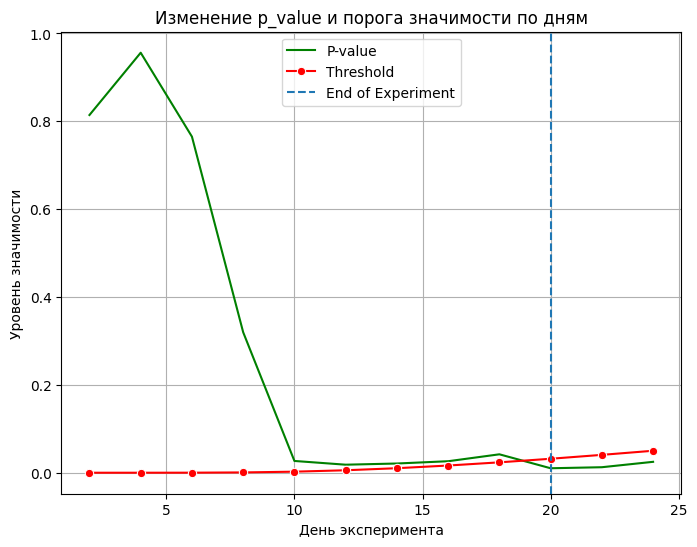

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.lineplot(history,
                  x='day',
                  y='p_value',
                  color='g',
                  label='P-value')

sns.lineplot(history,
             x='day',
             y='threshold',
             color='r',
             marker='o',
             label='Threshold',
             ax=ax)

plt.axvline(history[history.p_value < history.threshold].day.min(),
            linestyle='--', label='End of Experiment')
plt.title('Изменение p_value и порога значимости по дням')
plt.grid(True)
plt.xlabel('День эксперимента')
plt.ylabel('Уровень значимости')
plt.legend()

На графике видно, что p-value опустился ниже динамического порога **на 20-й день теста**.  

Однако тест **не был остановлен досрочно**, так как это учебный проект, и важно проследить за динамикой p-value на всей длительности эксперимента. Это позволяет:  

- Оценить, как меняется p-value по мере накопления данных.  
- Проверить, стабилизируется ли p-value или колеблется.  
- Проанализировать, как повлияла бы остановка теста на 20-м дне по сравнению с финальными результатами.  

В реальном A/B-тестировании досрочное завершение могло бы сэкономить время и ресурсы, но важно учитывать риск ложноположительных результатов.  


### Проверка гомогенности дисперсий  

Перед проведением t-теста надо убедиться, что дисперсии в контрольной и тестовой группах сильно не различаются.  
Для этого используем два теста:  

- **Levene test**
- **Bartlett test** 

Text(0, 0.5, 'Количество')

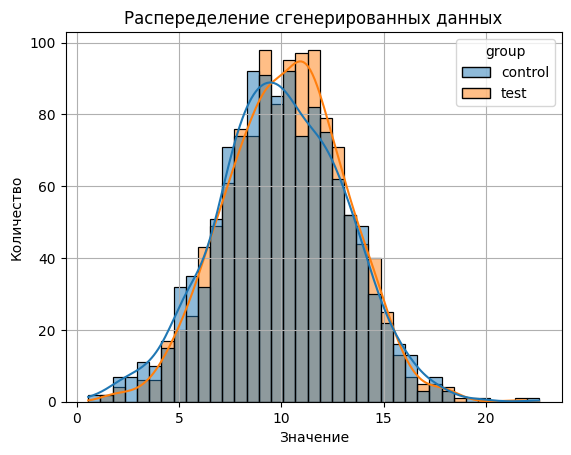

In [ ]:
plt.figsize=(8, 6)

sns.histplot(data, x='value', hue='group', kde=True)
plt.title('Распеределение сгенерированных данных')
plt.grid()
plt.xlabel('Значение')
plt.ylabel('Количество')

In [22]:
from scipy.stats import levene, bartlett  

stat_levene, p_levene = levene(control["value"], test["value"])
stat_bartlett, p_bartlett = bartlett(control["value"], test["value"])

print(f"Levene test: p-value = {p_levene:.4f}")
print(f"Bartlett test: p-value = {p_bartlett:.4f}")

Levene test: p-value = 0.0167
Bartlett test: p-value = 0.0061


Оба теста показали, что **значимых различий в дисперсиях нет**, следовательно, можно использовать **классический t-тест**, предполагающий равенство дисперсий в группах.

### Интерпретация t-теста  

In [26]:
from scipy import stats  

t_stat, p_value = stats.ttest_ind(control["value"], test["value"], equal_var=False)
print(f"T-статистика: {t_stat:.4f}, p-value: {p_value:.4f}")

T-статистика: -2.2458, p-value: 0.0248


Результаты t-теста:  

- **p-value = 0.0248**  
- Уровень значимости **α = 0.05**  

Так как **p-value < α**, мы отвергаем нулевую гипотезу \(H_0\) о равенстве средних значений в группах. Это означает, что **различия между контрольной и тестовой группами статистически значимы**.  

**Важно:** Несмотря на статистическую значимость, необходимо оценить практическую значимость разницы.  

### Оценка различий между группами  

Среднее увеличение прибыли: 0.2760130368544118


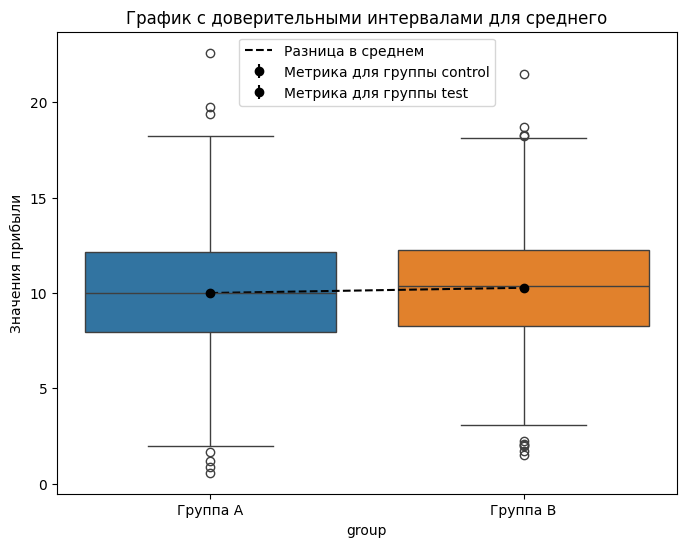

In [ ]:
control_values = control.value
test_values = test.value

mean_a = np.mean(control_values)
mean_b = np.mean(test_values)

profit_increase = mean_b - mean_a
print(f"Среднее увеличение прибыли: {profit_increase}")

ci_a = stats.t.interval(0.95, len(control_values)-1, loc=mean_a, scale=stats.sem(control_values))
ci_b = stats.t.interval(0.95, len(test_values)-1, loc=mean_b, scale=stats.sem(test_values))

plt.figure(figsize=(8, 6))
sns.boxplot(data, x='group', y='value', hue='group')

plt.plot([0, 1], [mean_a, mean_b], color='black', linestyle='--', label='Разница в среднем')

plt.errorbar(0, mean_a, yerr=[[mean_a - ci_a[0]], [ci_a[1] - mean_a]], fmt='o', color='black', label='Метрика для группы control')
plt.errorbar(1, mean_b, yerr=[[mean_b - ci_b[0]], [ci_b[1] - mean_b]], fmt='o', color='black', label='Метрика для группы test')

plt.xticks([0, 1], ['Группа A', 'Группа B'])
plt.ylabel('Значения прибыли')
plt.title('График с доверительными интервалами для среднего')
plt.legend()
plt.show()


Разница в целевой метрике между тестовой и контрольной группами составила **0.027**, что эквивалентно **2.7% от среднего значения**.  

In [6]:
control = data[data.group == 'control'].value
test = data[data.group == 'test'].value

pg.ttest(control, test)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.245761,2398,two-sided,0.02481,"[-0.52, -0.04]",0.091683,0.562,0.612152
